### Goals of this notebook:
### 1. Preprocesses the data to prepare for modeling
### 2. Modeling using a number of different models


In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

## I. Preprocessing
We get the data ready to model by dropping some features, creating dummy variables for catagorical features, and scaling the features.

In [2]:
import pickle
os.chdir("C:\Springboard\Github\Capstone2_cust\Intermediate_Data")

In [3]:
# load picked version of X
X = pickle.load(open("X2.pkl", "rb"))
# look at the first 10 rows of this file
X.head(10)

,first_total,Marketing_first,first_items,first_order,server,Vendor,Source,Area_Code,Ship_Zip,lead_sku,weekday,mon,first_tot_lg,first_it_lg,boost
1,145.58,1,2,2019-11-26 21:44:16+00:00,custom,1.0,web,404,30087,other,Tuesday,November,2.163102,0.30103,1
2,137.55,0,5,2019-11-26 20:52:08+00:00,custom,1.0,web,845,12545,other,Tuesday,November,2.138461,0.69897,1
3,22.98,1,2,2019-11-26 18:12:04+00:00,custom,1.0,web,262,53402,ROUTEINS10,Tuesday,November,1.361350,0.30103,1
4,28.00,0,1,2019-08-07 18:14:49+00:00,custom,0.0,web,617,01983,BEM1003,Wednesday,August,1.447158,0.00000,1
5,12.00,1,1,2019-08-07 18:05:28+00:00,custom,0.0,web,740,43143,other,Wednesday,August,1.079181,0.00000,1
6,42.00,0,2,2019-08-07 03:45:52+00:00,custom,0.0,web,701,58801,BES1006,Wednesday,August,1.623249,0.30103,1
7,27.20,1,1,2019-08-06 22:00:54+00:00,custom,0.0,web,754,33026,BEM6001,Tuesday,August,1.434569,0.00000,1
8,22.00,1,2,2019-08-06 20:22:25+00:00,custom,0.0,web,unknown,01880,BES5001,Tuesday,August,1.342423,0.30103,1
9,100.00,1,5,2019-08-06 19:59:05+00:00,custom,0.0,web,617,01880,BEM1007,Tuesday,August,2.000000,0.69897,1
10,36.64,1,2,2019-08-06 19:14:49+00:00,custom,0.0,web,626,92887,BEM1007,Tuesday,August,1.563955,0.30103,1


That looks pretty good. Let's review what each column means: <br>
- first_total: total $ spend on first order <br>
- Marketing_first: whether they accept marketing on the first order <br>
- first_items: number of items on first order <br>
- first_order: date-time of first order <br>
- server: domain name of the customer email server <br>
- vendor: 0 = first order from company; 1 = first order from outside source <br>
- Source: web or iphone
- Area_Code: area code of order placed
- Ship_Zip: zip code of shipping address
- lead_sku: name of SKU that was lead item on purchase
- weekday: day of week first order was placed
- mon: month that first order was placed
- first_tot_lg: log of first order total
- first_it_lg: log of number of items in first order <br>
<br>
The values for some of these catagorical features need to be converted to numbers

In [4]:
X['Source'].value_counts()

web        33949
1356615     5423
294517       273
457101        67
580111        16
412739         2
Name: Source, dtype: int64

In [5]:
# let's drop first order item log
X.drop('first_it_lg', axis=1, inplace=True)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39730 entries, 1 to 39770
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   first_total      39730 non-null  float64            
 1   Marketing_first  39730 non-null  int64              
 2   first_items      39730 non-null  int64              
 3   first_order      39730 non-null  datetime64[ns, UTC]
 4   server           39730 non-null  object             
 5   Vendor           39730 non-null  float64            
 6   Source           39730 non-null  object             
 7   Area_Code        39730 non-null  object             
 8   Ship_Zip         39730 non-null  object             
 9   lead_sku         39730 non-null  object             
 10  weekday          39730 non-null  object             
 11  mon              39730 non-null  object             
 12  first_tot_lg     39730 non-null  float64            
 13  boost           

traditional regression can't handle date-time, so we'll drop that

In [7]:
# drop date-time
X.drop('first_order', axis=1, inplace=True)

features that need dummy variables:
- server
- source
- Area_Code
- Ship_Zip
- lead_sku
- weekday
- mon <br>
<br>
Let's look at the size of these

In [8]:
X['server'].nunique()

26

In [9]:
X['Source'].nunique()

6

In [10]:
X['Area_Code'].nunique()

373

This is too man catagorical variables for this feature. I wonder if there are high concentrations of purchases in some zip codes that we could account for

In [11]:
X['Area_Code'].value_counts().head(20)

unknown    21387
949          273
714          204
720          161
760          155
310          148
214          144
512          144
817          139
801          135
757          132
208          131
917          131
909          130
503          130
916          129
704          129
360          128
619          127
303          121
Name: Area_Code, dtype: int64

There are 40k customers, so the largest area code makes up 0.68% of total orders. I think this feature is too small and would add unnecessary dimensions. We will drop.

In [12]:
X.drop('Area_Code', axis=1, inplace=True)

In [13]:
X['Ship_Zip'].nunique()

15930

That is way too many features. Unless they are very concentrated in a few zip codes, we'll drop it.

In [14]:
X['Ship_Zip'].value_counts().head(20)

92688      48
92692      48
unknown    48
92691      46
28532      41
92694      40
92630      39
92627      38
92656      31
92679      29
92677      27
92675      25
92672      24
92626      23
92629      22
92592      22
80013      22
92660      21
79936      20
93551      20
Name: Ship_Zip, dtype: int64

The largest zip code is still WAY too small. We'll drop this feature.

In [15]:
# drop that feature
X.drop('Ship_Zip', axis=1, inplace=True)

In [16]:
X['lead_sku'].nunique()

26

We know how many variables for days of the week and month there are. This means we should see: <br>
- server: 26
- source: 6
- lead_sku: 26
- weekday: 7
- mon: 12 <br>
- total: 77 more freatures <br>
<br>
That seems reasonable

In [17]:
# dummy for server ##
dfs = X['server']
dummy_server = pd.get_dummies(dfs)
X = pd.concat([X.drop('server', axis=1), dummy_server], axis=1)

In [18]:
# Dummy for Source
dfs = X['Source']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('Source', axis=1), dummy_source], axis=1)

In [19]:
# Dummy for lead_sku
dfs = X['lead_sku']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('lead_sku', axis=1), dummy_source], axis=1)

In [20]:
# Dummy for weekday
dfs = X['weekday']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('weekday', axis=1), dummy_source], axis=1)

In [21]:
# Dummy for weekday
dfs = X['mon']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('mon', axis=1), dummy_source], axis=1)
X

,first_total,Marketing_first,first_items,Vendor,first_tot_lg,boost,aim.com,aol.com,att.net,bellsouth.net,...,December,February,January,July,June,March,May,November,October,September
1,145.58,1,2,1.0,2.163102,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,137.55,0,5,1.0,2.138461,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,22.98,1,2,1.0,1.361350,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28.00,0,1,0.0,1.447158,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,12.00,1,1,0.0,1.079181,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39766,27.98,0,2,1.0,1.446848,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39767,59.97,0,2,1.0,1.777934,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39768,54.97,1,2,1.0,1.740126,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39769,90.68,0,3,1.0,1.957512,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


That looks good. Let's load Y.

In [22]:
# load picked version of X
y = pickle.load(open("Y2.pkl", "rb"))
# look at the first 10 rows of this file
y.head(10)

1     2.163102
2     2.138461
3     1.361350
4     1.447158
5     1.079181
6     1.623249
7     1.434569
8     1.342423
9     2.000000
10    1.563955
Name: life_lg, dtype: float64

In [23]:
# let's scale the X values
# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler = preprocessing.StandardScaler().fit(X)
# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled=scaler.transform(X)

In [24]:
# let's split the training and test sets
from sklearn.model_selection import train_test_split

# Get the 1-dimensional flattened array of our response variable y by calling the ravel() function on y
y = y.ravel()

# let's do the split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=1)

In [25]:
# let's quickly check that the Y means to make sure the data sets are similiar
y_train.mean(), y_test.mean()

(1.8158008483225205, 1.8162965793223824)

Those look reasonably close. <br>
<br>
That is the end of preprocessing. Time to model. 

## II. Modeling
We will try a few different models: <br>
- Linear Regression
- Random Forest Regressor
- Dummy Model (assume every customer is average)
- Gradient Boost Regression

In [26]:
# create list to track model performance
perform = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE'])

#### Model 1: Linear Regression

In [27]:
#first model from X-train
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [28]:
# predicted results from the first model on the X_test values
y_pred = model.predict(X_test)
# Mean Absolute Error
m1_MAE = mean_absolute_error(y_test, y_pred)
m1_MAE

10413803859.800573

In [29]:
# Mean Squared Error
m1_MSE = mean_squared_error(y_test, y_pred)
m1_MSE

4.3086116591378785e+23

These values seem extremely high. I want to look at some of the values in the model really quick.

In [30]:
print(lm.intercept_)

2082760773.7394059


That seems way off with linear regression. Let's see if Random Forest Regressor looks any better

In [31]:
# root mean squared error
m1_RMSE = m1_MSE**0.5

In [32]:
perform = perform.append({'Model':'Linear Regression', 'MAE':m1_MAE, 'MSE':m1_MSE, 'RMSE':m1_RMSE}, ignore_index=True)

#### 2. Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
# using a minimum sample of 40 or 1/1000th of the total number of customers
regr = RandomForestRegressor(min_samples_leaf=40, random_state=33)
model_rf = regr.fit(X_train,y_train)
y_pred_rf = regr.predict(X_test)

In [35]:
# Mean Absolute Error
m2_MAE = mean_absolute_error(y_test, y_pred_rf)
m2_MAE

0.184755203593603

In [36]:
# Mean Squared Error
m2_MSE = mean_squared_error(y_test, y_pred_rf)
m2_MSE

0.06807909868651355

In [37]:
# root mean squared error
m2_RMSE = m2_MSE**0.5
m2_RMSE

0.26091971693705623

That is so much better! <br>
Let's look at the importance of each feature

In [38]:
coff_m2 = pd.DataFrame(model_rf.feature_importances_, X.columns, columns=['Importance'])
coff_m2.sort_values('Importance', ascending=False).head(20)

,Importance
first_tot_lg,0.480089
first_total,0.460997
November,0.011767
1356615,0.007362
first_items,0.003836
gmail.com,0.003755
December,0.002959
Marketing_first,0.002906
January,0.002185
July,0.002086


These are good see. <br>
We may want to use these values to eliminate some variable from the regression model, but first let's compare the RMSE and AMSE to a dummy model that just assumes very customer is average 

In [39]:
# find the least important values
m2_unimportant = coff_m2.sort_values('Importance', ascending=True).head(25)
m2_unimportant

,Importance
BEM1007,0.0
me.com,0.0
msn.com,0.0
outlook.com,0.0
rocketmail.com,0.0
sbcglobal.net,0.0
vendor,0.0
mac.com,0.0
verizon.net,0.0
BES1005,0.0


All of these features have literally no importance on this Random Forest Regressor. We will use these later to drop from the features so that we can build a model that works with the important features only and doesn't waste time on these features.

In [40]:
perform = perform.append({'Model':'Random Forest 1', 'MAE':m2_MAE, 'MSE':m2_MSE, 'RMSE':m2_RMSE}, ignore_index=True)

#### 3. Dummy Model (average)

In [41]:
# assume the model is the average of the training data (we know this value)
y_pred_dm = np.full(y_test.size, y_train.mean())
# Mean Absolute Error
m3_MAE = mean_absolute_error(y_test, y_pred_dm)
m3_MAE

0.29065108266816125

In [42]:
# Mean Squared Error
m3_MSE = mean_squared_error(y_test, y_pred_dm)
m3_MSE

0.14451655741084168

In [43]:
# root mean squared error
m3_RMSE = m3_MSE**0.5
m3_RMSE

0.38015333407829227

These are worse than the Random Forest Regressor, so that's a good thing

In [44]:
# difference in root mean squared error between the two models
diff = m3_RMSE - m2_RMSE
diff

0.11923361714123604

In [45]:
# lifetime dollar value of that difference
10**diff

1.315932512657726

That is honestly not that impressive, but is still better than the dummy model. <br>
<br>
Let's see if we can use those results to improve the models after we try the Gradient Boosting Regression

In [46]:
perform = perform.append({'Model':'Dummy Model (average)', 'MAE':m3_MAE, 'MSE':m3_MSE, 'RMSE':m3_RMSE}, ignore_index=True)

#### 4. Gradient Boosting Regression

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
# create regressor
reg_gb = GradientBoostingRegressor(min_samples_leaf=40, random_state=0)
# fit the regressor
model_gb = reg_gb.fit(X_train,y_train)
# use regressor to predict on test data
y_pred_gb = regr.predict(X_test)
# compare test data for a score - Mean Absolute Error
m4_MAE = mean_absolute_error(y_test, y_pred_gb)
m4_MAE

0.184755203593603

In [49]:
# Mean Squared Error
m4_MSE = mean_squared_error(y_test, y_pred_gb)
m4_MSE

0.06807909868651355

In [50]:
# root mean squared error
m4_RMSE = m4_MSE**0.5
m4_RMSE

0.26091971693705623

These results are extremely good; they are very similar to the results from the Random Forest Regressor. We probably should improve these two models to get the best results. Let's look at the importance of each feature in the GB Regressor

In [51]:
# find the most important features
coff_m4 = pd.DataFrame(model_gb.feature_importances_, X.columns, columns=['Importance'])
coff_m4.sort_values('Importance', ascending=False).head(20)

,Importance
first_total,0.490292
first_tot_lg,0.456609
November,0.010038
1356615,0.006983
294517,0.003973
first_items,0.003904
457101,0.002933
BES1011,0.002509
July,0.002429
December,0.002158


In [52]:
# find the LEAST important features and eliminate those features from the X data set; then run the models again
m4_unimportant = coff_m4.sort_values('Importance', ascending=True).head(39)
m4_unimportant

,Importance
BEM1007,0.0
optonline.net,0.0
outlook.com,0.0
rocketmail.com,0.0
sbcglobal.net,0.0
vendor,0.0
verizon.net,0.0
windstream.net,0.0
ymail.com,0.0
BES3003,0.0


All of these features have literally no importance on this Gradient Boosting Regressor. We will use these to drop the features so that we can build a model that works with the important features only and doesn't waste time on these features.

In [53]:
perform = perform.append({'Model':'Gradient Boost 1', 'MAE':m4_MAE, 'MSE':m4_MSE, 'RMSE':m4_RMSE}, ignore_index=True)
perform

,Model,MAE,MSE,RMSE
0,Linear Regression,1.041380e+10,4.308612e+23,6.564002e+11
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01


### III. Remove unimportant features
The results from the first round of modeling were good, but there was a lot of unimportant features that were still considered by the models. Let's eliminate those features and see if we the models perform better.

In [54]:
# create a list of the unimportant features
unimport = list(set(m4_unimportant.index.tolist()) | set(m2_unimportant.index.tolist()))
# remove unimportant features from Gradient Boosting
X1 = X.drop(unimport, axis=1)
X1

,first_total,Marketing_first,first_items,Vendor,first_tot_lg,boost,custom,gmail.com,hotmail.com,yahoo.com,...,December,February,January,July,June,March,May,November,October,September
1,145.58,1,2,1.0,2.163102,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,137.55,0,5,1.0,2.138461,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,22.98,1,2,1.0,1.361350,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28.00,0,1,0.0,1.447158,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,12.00,1,1,0.0,1.079181,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39766,27.98,0,2,1.0,1.446848,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
39767,59.97,0,2,1.0,1.777934,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
39768,54.97,1,2,1.0,1.740126,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
39769,90.68,0,3,1.0,1.957512,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


That eliminated a lot of features and took us down to just 40 features! Excellent! <br>
<br>
Let's model with those features

In [55]:
# let's scale the X values
scaler1 = preprocessing.StandardScaler().fit(X1)
X1_scaled=scaler1.transform(X1)

# split the X and y values again
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=0.20, random_state=1)
# check the mean values of the y to make sure this is a good split
y_train.mean(), y_test.mean()


(1.8158008483225205, 1.8162965793223824)

#### 5. Linear regression on reduced feature data set

In [56]:
# try standard linear regression on the data set with less features
lm5 = linear_model.LinearRegression()
model5 = lm5.fit(X1_train,y_train)

In [57]:
# predicted results from the first model on the X_test values
y5_pred = model5.predict(X1_test)
# Mean Absolute Error
m5_MAE = mean_absolute_error(y_test, y5_pred)

In [58]:
# Mean Squared Error
m5_MSE = mean_squared_error(y_test, y5_pred)

In [59]:
# Root Mean Squared Error
m5_RMSE = m5_MSE**0.5

In [60]:
perform = perform.append({'Model':'Linear Regression 2', 'MAE':m5_MAE, 'MSE':m5_MSE, 'RMSE':m5_RMSE}, ignore_index=True)
perform.sort_values('RMSE', ascending=True)

,Model,MAE,MSE,RMSE
0,Linear Regression,1.041380e+10,4.308612e+23,6.564002e+11
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01


This updated version of linear regression actually performed better than the first attempt at Random Forest Regression or Gradient Boost Regression. That's great to see that eliminating those features lead to such improvement.

#### 6. Random Forest Regression with reduced features

In [61]:
# using a minimum sample of 40 or 1/1000th of the total number of customers
regr1 = RandomForestRegressor(min_samples_leaf=40, random_state=33)
model1_rf = regr.fit(X1_train,y_train)
y_pred1_rf = regr.predict(X1_test)

In [62]:
# Mean Absolute Error
m6_MAE = mean_absolute_error(y_test, y_pred1_rf)
# Mean Squared Error
m6_MSE = mean_squared_error(y_test, y_pred1_rf)
# root mean squared error
m6_RMSE = m6_MSE**0.5
# add to performance DF
perform = perform.append({'Model':'Random Forest 2', 'MAE':m6_MAE, 'MSE':m6_MSE, 'RMSE':m6_RMSE}, ignore_index=True)
perform.sort_values('RMSE', ascending=True)


,Model,MAE,MSE,RMSE
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01
5,Random Forest 2,1.847164e-01,6.809799e-02,2.609559e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
0,Linear Regression,1.041380e+10,4.308612e+23,6.564002e+11


these values look good, but similar to previous models

#### 7. Gradient Boost with Reduced Features

In [63]:
# create regressor
reg1_gb = GradientBoostingRegressor(min_samples_leaf=40, random_state=0)
model1_gb = reg_gb.fit(X1_train,y_train)
# use regressor to predict on test data
y_pred1_gb = regr.predict(X1_test)
# compare test data for a score - Mean Absolute Error
m7_MAE = mean_absolute_error(y_test, y_pred1_gb)
# Mean Squared Error
m7_MSE = mean_squared_error(y_test, y_pred1_gb)
# root mean squared error
m7_RMSE = m7_MSE**0.5
perform = perform.append({'Model':'Gradient Boost 2', 'MAE':m7_MAE, 'MSE':m7_MSE, 'RMSE':m7_RMSE}, ignore_index=True)
perform.sort_values('RMSE', ascending=True)


,Model,MAE,MSE,RMSE
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01
5,Random Forest 2,1.847164e-01,6.809799e-02,2.609559e-01
6,Gradient Boost 2,1.847164e-01,6.809799e-02,2.609559e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
0,Linear Regression,1.041380e+10,4.308612e+23,6.564002e+11


These look like great models (except for the first Linear Regression). Let's try XGBoost model next before moving on to hyperparameter tuning.

#### 8. XGBoost

In [64]:
# initiate the XGB Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
# fit the model
xg_reg.fit(X1_train,y_train)
# predict on the model
y_pred1_xgb = xg_reg.predict(X1_test)
# get scores of the model
m8_MAE = mean_absolute_error(y_test, y_pred1_xgb)
m8_MSE = mean_squared_error(y_test, y_pred1_xgb)
m8_RMSE = m8_MSE**0.5
perform = perform.append({'Model':'X Gradient Boost', 'MAE':m8_MAE, 'MSE':m8_MSE, 'RMSE':m8_RMSE}, ignore_index=True)
perform.sort_values('RMSE', ascending=True)

,Model,MAE,MSE,RMSE
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01
5,Random Forest 2,1.847164e-01,6.809799e-02,2.609559e-01
6,Gradient Boost 2,1.847164e-01,6.809799e-02,2.609559e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
7,X Gradient Boost,4.628376e-01,3.046849e-01,5.519827e-01
0,Linear Regression,1.041380e+10,4.308612e+23,6.564002e+11


XGBoost performed worse than the other models; maybe it's possible to Let's see if tuning the hyperparameters can make them better.

## IV. Hyperparameter Tuning

We took a guess at a good hyperparameter of 40 for the minimum number of leaves per node. That looked like a good start relative to the Linear Regression results. Instead, we should also consider multiple values for the hyperparameter for both the Gradient Boost and Random Forest Regressions

#### 9. Random Forest with Hyperparameter Tuning

In [68]:
import random
node_size = random.sample(range(10,1000), 20)

perform_h = pd.DataFrame(columns=['Model', 'Node_size', 'MAE', 'MSE', 'RMSE'])

# loops through the number of leaves
for n in node_size:
    reg_h = RandomForestRegressor(min_samples_leaf=n, random_state=33)
    model_rf_h = reg_h.fit(X1_train,y_train)
    y_pred1_rf_h = reg_h.predict(X1_test)
    # Mean Absolute Error
    MAE1 = mean_absolute_error(y_test, y_pred1_rf_h)
    # Mean Squared Error
    MSE1 = mean_squared_error(y_test, y_pred1_rf_h)
    # root mean squared error
    RMSE1 = MSE1**0.5
    # add to performance DF
    perform_h = perform_h.append({'Model':'Random Forest', 'Node_size':n, 'MAE':MAE1, 'MSE': MSE1, 'RMSE':RMSE1}, ignore_index=True)

perform_h.sort_values('RMSE', ascending=True)

,Model,Node_size,MAE,MSE,RMSE
7,Random Forest,239,0.188632,0.069005,0.262689
15,Random Forest,347,0.189736,0.069330,0.263306
3,Random Forest,354,0.189758,0.069337,0.263319
19,Random Forest,380,0.190055,0.069414,0.263466
14,Random Forest,452,0.190823,0.069658,0.263928
9,Random Forest,483,0.191057,0.069721,0.264048
18,Random Forest,496,0.191157,0.069765,0.264131
17,Random Forest,598,0.191510,0.069913,0.264410
5,Random Forest,607,0.191561,0.069928,0.264438
2,Random Forest,670,0.191950,0.070038,0.264647


These all look extremely similiar, let's plot the results

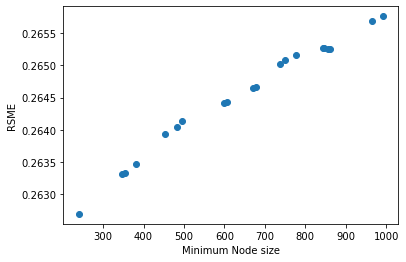

In [69]:
# plot the minimum node size versus the RSME
plt.scatter(perform_h['Node_size'], perform_h['RMSE'])
plt.xlabel('Minimum Node size')
plt.ylabel('RSME')
plt.show()

That looks like it trends downwards with smaller minimum node size, as it's allowed to fit the model more closely to the data. Let's try a different range of values to select from and iterate one more time on that hyperparameter

In [70]:
# much smaller minimum node size 
node_size = random.sample(range(5,30), 20)

# we'll add on to the existing DF so we get a better look at the full curve

# loops through the number of leaves
for n in node_size:
    reg_h = RandomForestRegressor(min_samples_leaf=n, random_state=33)
    model_rf_h = reg_h.fit(X1_train,y_train)
    y_pred1_rf_h = reg_h.predict(X1_test)
    # Mean Absolute Error
    MAE1 = mean_absolute_error(y_test, y_pred1_rf_h)
    # Mean Squared Error
    MSE1 = mean_squared_error(y_test, y_pred1_rf_h)
    # root mean squared error
    RMSE1 = MSE1**0.5
    # add to performance DF
    perform_h = perform_h.append({'Model':'Random Forest Tune 1', 'Node_size':n, 'MAE':MAE1, 'MSE': MSE1, 'RMSE':RMSE1}, ignore_index=True)

perform_h.sort_values('RMSE', ascending=True)

,Model,Node_size,MAE,MSE,RMSE
33,Random Forest,26,0.183902,0.067985,0.260739
23,Random Forest,27,0.183972,0.067993,0.260755
28,Random Forest,28,0.184057,0.068003,0.260774
27,Random Forest,29,0.184104,0.068008,0.260783
35,Random Forest,23,0.183768,0.068012,0.260790
30,Random Forest,19,0.183530,0.068024,0.260814
20,Random Forest,24,0.183825,0.068027,0.260821
36,Random Forest,20,0.183665,0.068039,0.260842
37,Random Forest,18,0.183516,0.068054,0.260872
25,Random Forest,17,0.183460,0.068070,0.260902


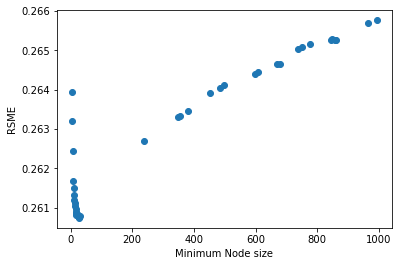

In [71]:
# plot the minimum node size versus the RSME
plt.scatter(perform_h['Node_size'], perform_h['RMSE'])
plt.xlabel('Minimum Node size')
plt.ylabel('RSME')
plt.show()

That is the dip that I wanted to see to consider a balance between under and over-fitting to the data. Let's find the best value.

In [72]:
perform_h.sort_values('RMSE', ascending=True).head(10)

,Model,Node_size,MAE,MSE,RMSE
33,Random Forest,26,0.183902,0.067985,0.260739
23,Random Forest,27,0.183972,0.067993,0.260755
28,Random Forest,28,0.184057,0.068003,0.260774
27,Random Forest,29,0.184104,0.068008,0.260783
35,Random Forest,23,0.183768,0.068012,0.260790
30,Random Forest,19,0.183530,0.068024,0.260814
20,Random Forest,24,0.183825,0.068027,0.260821
36,Random Forest,20,0.183665,0.068039,0.260842
37,Random Forest,18,0.183516,0.068054,0.260872
25,Random Forest,17,0.183460,0.068070,0.260902


It looks like 26 is the best minimum node size for Random Forest Regression with this data. We'll add this to the overall performance dataframe.

In [74]:
perform = perform.append(perform_h.sort_values('RMSE', ascending=True).head(1), ignore_index=True)
perform.sort_values('RMSE', ascending=True)


,Model,MAE,MSE,RMSE,Node_size
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01,NaN
9,Random Forest,1.839021e-01,6.798485e-02,2.607391e-01,26
10,Random Forest,1.839021e-01,6.798485e-02,2.607391e-01,26
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01,NaN
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01,NaN
5,Random Forest 2,1.847164e-01,6.809799e-02,2.609559e-01,NaN
6,Gradient Boost 2,1.847164e-01,6.809799e-02,2.609559e-01,NaN
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01,NaN
7,X Gradient Boost,4.628376e-01,3.046849e-01,5.519827e-01,NaN
8,X Gradient Boost,4.628376e-01,3.046849e-01,5.519827e-01,NaN


The tuned RF did perform slightly better than the previous implementations of random forest, but still not as good as the 2nd attempt at Linear Regression. Let's try to tune the Gradient Boosting next.

#### 10. Gradient Boosting with Hyperparameter Tuning

Let's do the same hyperparameter tuning, but with Gradient Boosting. Learning Rate is the most important parameter in GB, so we'll tune that throughout the range.

In [76]:
# much smaller minimum node size 
learn_rt = [random.random()*0.4 for x in range(20)]

# we'll add on to the existing DF so we get a better look at the full curve
perform_gb = pd.DataFrame(columns=['Model', 'Learning_rate', 'MAE', 'MSE', 'RMSE'])

# loops through the number of leaves
for r in learn_rt:
    reg_gb = GradientBoostingRegressor(learning_rate=r, random_state=0)
    model_gb = reg_gb.fit(X1_train,y_train)
    # use regressor to predict on test data
    y_pred_gb = regr.predict(X1_test)
    # Mean Absolute Error
    MAE1 = mean_absolute_error(y_test, y_pred_gb)
    # Mean Squared Error
    MSE1 = mean_squared_error(y_test, y_pred_gb)
    # root mean squared error
    RMSE1 = MSE1**0.5
    # add to performance DF
    perform_gb = perform_gb.append({'Model':'Gradient Boost', 'Learning_rate':r, 'MAE':MAE1, 'MSE': MSE1, 'RMSE':RMSE1}, ignore_index=True)

perform_gb.sort_values('RMSE', ascending=True).head(10)

,Model,Learning_rate,MAE,MSE,RMSE
0,Gradient Boost,0.348216,0.184716,0.068098,0.260956
17,Gradient Boost,0.043508,0.184716,0.068098,0.260956
16,Gradient Boost,0.186289,0.184716,0.068098,0.260956
15,Gradient Boost,0.141193,0.184716,0.068098,0.260956
14,Gradient Boost,0.243605,0.184716,0.068098,0.260956
13,Gradient Boost,0.329290,0.184716,0.068098,0.260956
12,Gradient Boost,0.056818,0.184716,0.068098,0.260956
11,Gradient Boost,0.224513,0.184716,0.068098,0.260956
10,Gradient Boost,0.373182,0.184716,0.068098,0.260956
9,Gradient Boost,0.151483,0.184716,0.068098,0.260956


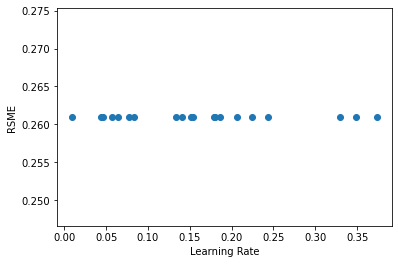

In [77]:
# plot the minimum node size versus the RSME
plt.scatter(perform_gb['Learning_rate'], perform_gb['RMSE'])
plt.xlabel('Learning Rate')
plt.ylabel('RSME')
plt.show()

Looks like the results are pretty much exactly as we planned them to be. 

## V. More Extensive Hyperparameter Tuning

In the previous section, we did some hyperparameter tuning, but this was just using a random search of one parameter. It may not even be the best parameter to tune. Instead, we will focus on doing a more extensive search in this section. We will form a grid for both Random Forest and Gradient Boosting. We will then using random search to pick out some points on that grid.

#### 11. Random Forest Regression with more extensive Hyperparameter Tuning (using multiple hyperparameters)

In [78]:
### create the grid of hyperparameters to use

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 26, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 26, 40]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [5, 10, 26, 40], 'min_samples_leaf': [5, 10, 26, 40], 'bootstrap': [True, False]}


In [79]:
## run the random search of that grid that we just created

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 3, verbose=2, random_state=33, n_jobs = -1)
# Fit the random search model
rf_random.fit(X1_train, y_train)


Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 211.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 310.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [80]:
# print the best parameters
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 26,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [81]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=26, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [82]:
# let's see how these parameters performed
# rf_h = RandomForestRegressor(rf_random.best_params_)
model_rf_h = rf_random.best_estimator_
y_pred_h_rf = model_rf_h.predict(X1_test)

# let's see the error
# Mean Absolute Error
rf_h_MAE = mean_absolute_error(y_test, y_pred_h_rf)
# Mean Squared Error
rf_h_MSE = mean_squared_error(y_test, y_pred_h_rf)
# root mean squared error
rf_h_RMSE = m6_MSE**0.5

# display
rf_h_MAE, rf_h_MSE, rf_h_RMSE


(0.1848952784978411, 0.0677108711368598, 0.2609559220699036)

This is barely any different the the resutls we got from the values we had previously, but I will still use those values in future Random Forest Models with this data. Let's add it to the performance dataframe

In [83]:
perform = perform.append({'Model':'Random Forest Hyper Tune', 'MAE':rf_h_MAE, 'MSE':rf_h_MSE, 'RMSE':rf_h_RMSE}, ignore_index=True)
perform.sort_values('RMSE', ascending=True)

,Model,MAE,MSE,RMSE,Node_size
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01,NaN
9,Random Forest,1.839021e-01,6.798485e-02,2.607391e-01,26
10,Random Forest,1.839021e-01,6.798485e-02,2.607391e-01,26
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01,NaN
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01,NaN
5,Random Forest 2,1.847164e-01,6.809799e-02,2.609559e-01,NaN
6,Gradient Boost 2,1.847164e-01,6.809799e-02,2.609559e-01,NaN
11,Random Forest Hyper Tune,1.848953e-01,6.771087e-02,2.609559e-01,NaN
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01,NaN
7,X Gradient Boost,4.628376e-01,3.046849e-01,5.519827e-01,NaN


#### 12. Grandient Boost Regression with more extensive Hyperparameter Tuning

In [66]:
### create the grid of hyperparameters to use

# Number of estimators in XGBoost
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# learning rate
learn_rt = [0.0001, 0.001, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 26, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10, 26, 40]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid_gb = {'n_estimators': n_estimators, 'learning_rate': learn_rt, 'max_features': max_features,'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf
              }
print(random_grid_gb)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'learning_rate': [0.0001, 0.001, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 26, 40], 'min_samples_leaf': [1, 5, 10, 26, 40]}


In [68]:
## run the random search of that grid that we just created
from sklearn.model_selection import RandomizedSearchCV

# First create the base model to tune
gbr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid_gb, n_iter = 100, cv = 3, verbose=2, random_state=33, n_jobs = -1)
# Fit the random search model
gbr_random.fit(X1_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 59.1min
C:\Users\sjrek\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 314.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 649.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [69]:
# print the best parameters
gbr_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 26,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'learning_rate': 0.02}

In [70]:
# print the best score
gbr_random. best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.02, loss='ls',
                          max_depth=10, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=26, min_weight_fraction_leaf=0.0,
                          n_estimators=600, n_iter_no_change=None,
                          presort='deprecated', random_state=None,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [71]:
# let's see how these parameters performed
# rf_h = RandomForestRegressor(rf_random.best_params_)
model_gb_h = gbr_random.best_estimator_
y_pred_h_gb = model_gb_h.predict(X1_test)

# let's see the error
# Mean Absolute Error
gb_h_MAE = mean_absolute_error(y_test, y_pred_h_gb)
# Mean Squared Error
gb_h_MSE = mean_squared_error(y_test, y_pred_h_gb)
# root mean squared error
gb_h_RMSE = gb_h_MSE**0.5

# display
gb_h_MAE, gb_h_MSE, gb_h_RMSE

(0.18329852272669095, 0.06886263156505527, 0.2624169041145316)

In [72]:
# add these to the performance matrix
perform = perform.append({'Model':'Gradient Boost Hyper Tune', 'MAE':gb_h_MAE, 'MSE':gb_h_MSE, 'RMSE':gb_h_RMSE}, ignore_index=True)
perform.sort_values('RMSE', ascending=True)

,Model,MAE,MSE,RMSE
4,Linear Regression 2,1.859726e-01,6.770457e-02,2.602010e-01
1,Random Forest 1,1.847552e-01,6.807910e-02,2.609197e-01
3,Gradient Boost 1,1.847552e-01,6.807910e-02,2.609197e-01
5,Random Forest 2,1.847164e-01,6.809799e-02,2.609559e-01
6,Gradient Boost 2,1.847164e-01,6.809799e-02,2.609559e-01
8,Gradient Boost Hyper Tune,1.832985e-01,6.886263e-02,2.624169e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
7,X Gradient Boost,4.628376e-01,3.046849e-01,5.519827e-01
0,Linear Regression,1.041380e+10,4.308612e+23,6.564002e+11


This is good to see that hyperparameter tuning didn't help Gradient Boosting much. Linear Regression still appears to be the best model. <br>
We should probably consider ensemble model with Linear Regression and using Random Forest on the residuals.